In [10]:
from pyspark.sql import SparkSession
import os 
spark = SparkSession.builder.appName("name02").getOrCreate()

In [11]:
import pyspark.sql.functions as F 

# MissingData
Spark provides a dedicated class called DataFrameNaFunctions to help in
dealing with this inconvenient issue.

In [4]:
badMovies = [(None, None, None),\
            (None, None, 2018),\
            ("John Doe", "Awesome Movie", None),\
            (None, "Awesome Movie", 2018),\
            ("Mary Jane", None, 2018)\
            ]


In [5]:
badMoviesDF = spark.createDataFrame(badMovies, [ 'actor_name','movie_title','produced_year'])
badMoviesDF.show()

+----------+-------------+-------------+
|actor_name|  movie_title|produced_year|
+----------+-------------+-------------+
|      null|         null|         null|
|      null|         null|         2018|
|  John Doe|Awesome Movie|         null|
|      null|Awesome Movie|         2018|
| Mary Jane|         null|         2018|
+----------+-------------+-------------+



## drop NA (any)
If the row has at least 1 NA, drop it

In [6]:
# dropping rows that have missing data in any column
# both of the lines below achieve the same output
badMoviesDF.na.drop().show()
badMoviesDF.na.drop("any").show()

+----------+-----------+-------------+
|actor_name|movie_title|produced_year|
+----------+-----------+-------------+
+----------+-----------+-------------+

+----------+-----------+-------------+
|actor_name|movie_title|produced_year|
+----------+-----------+-------------+
+----------+-----------+-------------+



## drop ALL
drop rows that have missing data in every single column

In [7]:
badMoviesDF.na.drop("all").show()

+----------+-------------+-------------+
|actor_name|  movie_title|produced_year|
+----------+-------------+-------------+
|      null|         null|         2018|
|  John Doe|Awesome Movie|         null|
|      null|Awesome Movie|         2018|
| Mary Jane|         null|         2018|
+----------+-------------+-------------+



## Drop Subset
drops rows that column actor_name has missing data


In [8]:
badMoviesDF.na.drop(subset=["actor_name"]).show()

+----------+-------------+-------------+
|actor_name|  movie_title|produced_year|
+----------+-------------+-------------+
|  John Doe|Awesome Movie|         null|
| Mary Jane|         null|         2018|
+----------+-------------+-------------+



# Actions



| Operation               | Description                                                                                                                                                                                                                               |
|-------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `show()`                | Display the row in a tabular format. If `numRows` is not specified, it shows the top 20 rows. The `truncate` option controls whether to truncate a string column if it is longer than 20 characters.                                       |
| `show(numRows)`         | Display the top `numRows` rows.                                                                                                                                                                                                           |
| `show(truncate)`        | Truncate a string column if it is longer than 20 characters.                                                                                                                                                                              |
| `show(numRows, truncate)` | Display the top `numRows` rows and truncate a string column if it is longer than 20 characters.                                                                                                                                           |
| `head()`                | Return the first row.                                                                                                                                                                                                                     |
| `first()`               | Alias for `head()`.                                                                                                                                                                                                                       |
| `head(n)`               | Return the first `n` rows.                                                                                                                                                                                                                |
| `take(n)`               | Alias for `head(n)`.                                                                                                                                                                                                                      |
| `takeAsList(n)`         | Return the first `n` rows as a Java list. Be careful not to take too many rows; otherwise, it may cause an out-of-memory error on the application’s driver process.                                                                       |
| `collect`               | Return all the rows as an array or a Java list. Apply the same caution as the one described in `takeAsList` action.                                                                                                                       |
| `collectAsList`         | Alias for `collect`.                                                                                                                                                                                                                      |
| `count`                 | Return the number of rows in the DataFrame.                                                                                                                                                                                               |
| `describe`              | Compute common statistics about numeric and string columns in the DataFrame. Available statistics are count, mean, stddev, min, max, and arbitrary approximate percentiles.                                                                |


In [9]:
badMoviesDF.describe("produced_year").show()

+-------+-------------+
|summary|produced_year|
+-------+-------------+
|  count|            3|
|   mean|       2018.0|
| stddev|          0.0|
|    min|         2018|
|    max|         2018|
+-------+-------------+



# Write Df
> **Common Interacting Pattern with DataFrameWriter** <br>
movies.write.format(...).mode(...).option(...).partitionBy(...).bucketBy(..
.).sortBy(...).save(path)

> The save mode

| Mode            | Description                                                                                                                                                      |
|-----------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `append`        | This appends the DataFrame data to the list of files that already exist at the specified destination location.                                                    |
| `overwrite`     | This completely overwrites any data files that already exist at the specified destination location with the data in the DataFrame.                                |
| `error`         | This is the default mode. If the specified destination location exists, then `DataFrameWriter` throws an error.                                                   |
| `errorIfExists` | Alias for `error`.                                                                                                                                               |
| `default`       | Alias for `error`.                                                                                                                                               |
| `ignore`        | If the specified destination location exists, then simply do nothing. In other words, silently don’t write out the data in the DataFrame.                         |


In [ ]:
# write data out in CVS format, but using a '#' as delimiter
movies.write.format("csv").option("sep", "#").save("/tmp/output/csv")

# write data out using overwrite save mode
movies.write.format("csv").mode("overwrite").option("sep", "#").save("/tmp/output/csv")

##  partitioning and bucketing
> The DataFrameWriter
writes out all the movies with the same produced_year into a single directory. The
number of directories in the output folder corresponds to the number of years in the
movies DataFrame.

In [ ]:
#Write the movies DataFrame Using Partition By produced_year Column
movies.write.partitionBy("produced_year").save("/tmp/output/movies ")

# Aggregations

The grouping of rows can be done at different levels, and Spark
supports the following levels.

* Treat a DataFrame as one group.
* Divide a DataFrame into multiple groups using one or more columns
and perform one or more aggregations on each group.
* Divide a DataFrame into multiple windows and perform moving
average, cumulative sum, or ranking. If a window is based on time,
the aggregations can be done per tumbling or sliding windows

## Aggregation Functions
In Spark, all aggregations are done via functions. The aggregation functions are designed
to perform aggregation on a set of rows 
| Operation             | Description                                                                                                             |
|-----------------------|-------------------------------------------------------------------------------------------------------------------------|
| `count(col)`          | Return the number of items per group.                                                                                   |
| `countDistinct(col)`  | Return the unique number of items per group.                                                                            |
| `approx_count_distinct(col)` | Return the approximate number of unique items per group.                                                                |
| `min(col)`            | Return the minimum value of the given column per group.                                                                 |
| `max(col)`            | Return the maximum value of the given column per group.                                                                 |
| `sum(col)`            | Return the sum of the values in the given column per group.                                                             |
| `sumDistinct(col)`    | Return the sum of the distinct values of the given column per group.                                                    |
| `avg(col)`            | Return the average of the values of the given column per group.                                                         |
| `skewness(col)`       | Return the skewness of the distribution of the values of the given column per group.                                    |
| `kurtosis(col)`       | Return the kurtosis of the distribution of the values of the given column per group.                                    |
| `variance(col)`       | Return the unbiased variance of the values of the given column per group.                                               |
| `stddev(col)`         | Return the standard deviation of the values of the given column per group.                                              |
| `collect_list(col)`   | Return a collection of values of the given column. The returned collection may contain duplicate values.                |
| `collect_set(col)`    | Return a collection of unique values of the given column.                                                               |



In [38]:
path = "/home/msi/beginning-apache-spark-3/"
path = os.path.join(path,"chapter4/data/flights/flight-summary.csv")
path

'/home/msi/beginning-apache-spark-3/chapter4/data/flights/flight-summary.csv'

In [39]:
flight_summary = spark.read.format("csv")\
.option("header", "true")\
.option("inferSchema","true")\
.load(path)

In [40]:
flight_summary.show(5,False)

+-----------+------------------------------------------+------------+------------+---------+----------------------------------------+---------+----------+-----+
|origin_code|origin_airport                            |origin_city |origin_state|dest_code|dest_airport                            |dest_city|dest_state|count|
+-----------+------------------------------------------+------------+------------+---------+----------------------------------------+---------+----------+-----+
|BQN        |Rafael Hernández Airport                  |Aguadilla   |PR          |MCO      |Orlando International Airport           |Orlando  |FL        |441  |
|PHL        |Philadelphia International Airport        |Philadelphia|PA          |MCO      |Orlando International Airport           |Orlando  |FL        |4869 |
|MCI        |Kansas City International Airport         |Kansas City |MO          |IAH      |George Bush Intercontinental Airport    |Houston  |TX        |1698 |
|SPI        |Abraham Lincoln Capit

In [41]:
flight_summary.printSchema()

root
 |-- origin_code: string (nullable = true)
 |-- origin_airport: string (nullable = true)
 |-- origin_city: string (nullable = true)
 |-- origin_state: string (nullable = true)
 |-- dest_code: string (nullable = true)
 |-- dest_airport: string (nullable = true)
 |-- dest_city: string (nullable = true)
 |-- dest_state: string (nullable = true)
 |-- count: integer (nullable = true)



In [43]:
flight_summary.describe().show()

24/05/19 14:34:35 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------+--------------------+-----------+------------+---------+--------------------+---------+----------+------------------+
|summary|origin_code|      origin_airport|origin_city|origin_state|dest_code|        dest_airport|dest_city|dest_state|             count|
+-------+-----------+--------------------+-----------+------------+---------+--------------------+---------+----------+------------------+
|  count|       4693|                4693|       4693|        4693|     4693|                4693|     4693|      4693|              4693|
|   mean|       null|                null|       null|        null|     null|                null|     null|      null|1136.3549968037503|
| stddev|       null|                null|       null|        null|     null|                null|     null|      null| 1370.779981308405|
|    min|        ABE|Aberdeen Regional...|   Aberdeen|          AK|      ABE|Aberdeen Regional...| Aberdeen|        AK|                 1|
|    max|        YUM|Yuma I

## Count
When counting the number of items in a column, the count(col) function doesn’t
include the null value in the count.

In [45]:
flight_summary.select(F.count("origin_airport"),\
                    F.count("dest_airport").alias("destination_airport")).show()

+---------------------+-------------------+
|count(origin_airport)|destination_airport|
+---------------------+-------------------+
|                 4693|               4693|
+---------------------+-------------------+



> Example with NULLs

In [51]:
## example with nulls
ex = [(None, None, 2018),\
("John Doe", "Awesome Movie", 2018),\
(None, "Awesome Movie", 2018),\
("Mary Jane", "Awesome Movie", 2018)]

exWithNullDF = spark.createDataFrame(ex, ["actor_name","movie_title","produced_year"])
exWithNullDF.show()

+----------+-------------+-------------+
|actor_name|  movie_title|produced_year|
+----------+-------------+-------------+
|      null|         null|         2018|
|  John Doe|Awesome Movie|         2018|
|      null|Awesome Movie|         2018|
| Mary Jane|Awesome Movie|         2018|
+----------+-------------+-------------+



> count

In [50]:
exWithNullDF.select(F.count("actor_name"), F.count("movie_title"),\
                    F.count("produced_year"), F.count("*")).show()

+-----------------+------------------+--------------------+--------+
|count(actor_name)|count(movie_title)|count(produced_year)|count(1)|
+-----------------+------------------+--------------------+--------+
|                2|                 3|                   4|       4|
+-----------------+------------------+--------------------+--------+



## countDistinct(col)

In [53]:
flight_summary.select(F.countDistinct("origin_airport"),
                    F.countDistinct("dest_airport"), F.count("origin_airport")).show()

+------------------------------+----------------------------+---------------------+
|count(DISTINCT origin_airport)|count(DISTINCT dest_airport)|count(origin_airport)|
+------------------------------+----------------------------+---------------------+
|                           322|                         322|                 4693|
+------------------------------+----------------------------+---------------------+



> `countDistict` over large DataSet is an expensive operation <br>
> In some use cases, it is sufficient to have an
approximate unique count

In [56]:
flight_summary.select(F.countDistinct("origin_airport"), F.approx_count_distinct("origin_airport")).show()

+------------------------------+-------------------------------------+
|count(DISTINCT origin_airport)|approx_count_distinct(origin_airport)|
+------------------------------+-------------------------------------+
|                           322|                                  316|
+------------------------------+-------------------------------------+



## min(col), max(col)

In [60]:
flight_summary.select(F.min("count"), F.max("count")).show()

+----------+----------+
|min(count)|max(count)|
+----------+----------+
|         1|     13744|
+----------+----------+



## sum(col)
This function computes the sum of the values in a numeric column

In [62]:
flight_summary.select(F.sum("count")).show()

+----------+
|sum(count)|
+----------+
|   5332914|
+----------+



## sumDistinct(col)
It sums up only the distinct values of a numeric column. 

In [63]:
flight_summary.select(F.sum("count"), F.sumDistinct("count")).show()

+----------+-------------------+
|sum(count)|sum(DISTINCT count)|
+----------+-------------------+
|   5332914|            3612257|
+----------+-------------------+



/home/msi/spark-3.4.0-bin-hadoop3/python/pyspark/sql/functions.py:752: FutureWarning: Deprecated in 3.2, use sum_distinct instead.
  warnings.warn("Deprecated in 3.2, use sum_distinct instead.", FutureWarning)


## avg(col)
This function calculates the average value of a numeric column. 

In [64]:
# Computing the Average Value of the Count Column Using Two Different Ways
flight_summary.select(F.avg("count"),\
                    (F.sum("count") / F.count("count"))).show()

+------------------+---------------------------+
|        avg(count)|(sum(count) / count(count))|
+------------------+---------------------------+
|1136.3549968037503|         1136.3549968037503|
+------------------+---------------------------+



## skewness(col), kurtosis(col)
Skewness measures the symmetry of the value distribution in a dataset, and its
value can be positive, zero, negative, or undefined. <br>
* normal distribution = 0
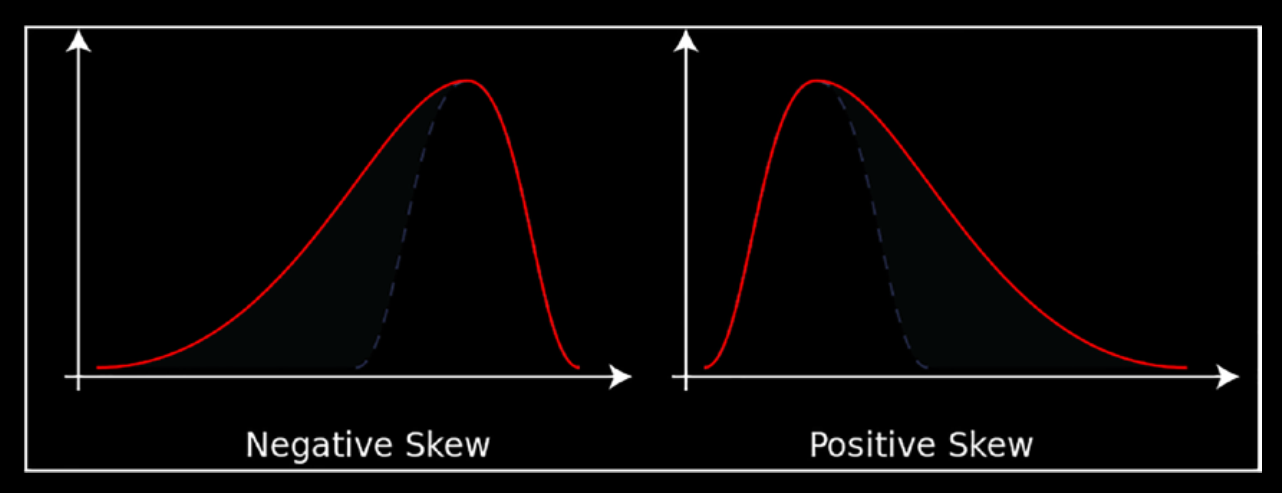

Kurtosis is a measure of the shape of the distribution curve, whether the curve is
normal, flat, or pointy. 
* Positive kurtosis indicates the curve is slender and pointy 
* negative kurtosis indicates fat and flat.

In [65]:
flight_summary.select(F.skewness("count"), F.kurtosis("count")).show()

+-----------------+-----------------+
|  skewness(count)|  kurtosis(count)|
+-----------------+-----------------+
|2.682183800064101|10.51726963017102|
+-----------------+-----------------+



> The result suggests the distribution of the counts is not symmetric, and the right tail
is longer or fatter than the left tail. The kurtosis value suggests that the distribution curve is pointy.

## variance(col), stddev(col)


In [67]:
# use the two variations of variance and standard deviation
flight_summary.select(F.variance("count"), F.var_pop("count"), F.stddev("count"),
F.stddev_pop("count")).show()

+------------------+------------------+------------------+-----------------+
|   var_samp(count)|    var_pop(count)|stddev_samp(count)|stddev_pop(count)|
+------------------+------------------+------------------+-----------------+
|1879037.7571558713|1878637.3655604832| 1370.779981308405|1370.633928355957|
+------------------+------------------+------------------+-----------------+



# Aggregation with Grouping

instead of performing aggregation on the global group in
the DataFrame, they perform the aggregation on each subgroup.
> the groupBy transformation returns an instance of
RelationalGroupedDataset class, to which you can apply one or more aggregation
functions. 

In [73]:
flight_summary.groupBy("origin_airport").count().show(5, False)

+-------------------------------------------------+-----+
|origin_airport                                   |count|
+-------------------------------------------------+-----+
|Melbourne International Airport                  |1    |
|San Diego International Airport (Lindbergh Field)|46   |
|Eppley Airfield                                  |21   |
|Kahului Airport                                  |18   |
|Austin-Bergstrom International Airport           |41   |
+-------------------------------------------------+-----+
only showing top 5 rows



In [77]:
flight_summary.printSchema()

root
 |-- origin_code: string (nullable = true)
 |-- origin_airport: string (nullable = true)
 |-- origin_city: string (nullable = true)
 |-- origin_state: string (nullable = true)
 |-- dest_code: string (nullable = true)
 |-- dest_airport: string (nullable = true)
 |-- dest_city: string (nullable = true)
 |-- dest_state: string (nullable = true)
 |-- count: integer (nullable = true)



In [79]:
# the column count gets the name count automatically, this way is dangerous
flight_summary.groupBy("origin_state", "origin_city").count()\
    .where(F.col("origin_state") == "CA").show()

+------------+-------------+-----+
|origin_state|  origin_city|count|
+------------+-------------+-----+
|          CA|      Oakland|   35|
|          CA|   Long Beach|   12|
|          CA|     San Jose|   25|
|          CA|Mammoth Lakes|    2|
|          CA|       Fresno|    9|
|          CA|  Santa Maria|    2|
|          CA|Santa Barbara|    6|
|          CA|      Redding|    1|
|          CA|   Sacramento|   27|
|          CA|    Santa Ana|   22|
|          CA|San Francisco|   80|
|          CA|      Ontario|   14|
|          CA|Arcata/Eureka|    1|
|          CA|  Bakersfield|    4|
|          CA|      Burbank|   11|
|          CA|     Monterey|    3|
|          CA|    San Diego|   47|
|          CA| Palm Springs|   12|
|          CA|  Los Angeles|   80|
|          CA|Crescent City|    1|
+------------+-------------+-----+
only showing top 20 rows



In [84]:
# better this indirect way using the AGG
flight_summary.groupBy("origin_state", "origin_city")\
    .agg(F.count("*").alias("my_col_name"))\
    .orderBy(F.col("my_col_name").desc())\
    .where(F.col("origin_state") == "NM").show()

+------------+-----------+-----------+
|origin_state|origin_city|my_col_name|
+------------+-----------+-----------+
|          NM|Albuquerque|         23|
|          NM|   Santa Fe|          3|
|          NM|    Roswell|          1|
|          NM|      Hobbs|          1|
+------------+-----------+-----------+



## Multiple Aggregations per Group

In [89]:
flight_summary.groupBy("origin_airport")\
    .agg(F.count("count").alias("count(count)")
        ,F.min("count")
        ,F.max("count")
        ,F.sum("count")
    ).orderBy(F.col("count(count)").desc()).show(5, False)

+------------------------------------------------+------------+----------+----------+----------+
|origin_airport                                  |count(count)|min(count)|max(count)|sum(count)|
+------------------------------------------------+------------+----------+----------+----------+
|Hartsfield-Jackson Atlanta International Airport|169         |1         |8234      |346836    |
|Chicago O'Hare International Airport            |162         |2         |9575      |285884    |
|Dallas/Fort Worth International Airport         |148         |63        |7870      |239551    |
|Denver International Airport                    |139         |2         |7211      |196055    |
|Minneapolis-Saint Paul International Airport    |120         |1         |6296      |112117    |
+------------------------------------------------+------------+----------+----------+----------+
only showing top 5 rows



## Collection Group Values
The collect_list(col) and collect_set(col) functions are useful to collect all
the values of a particular group after the grouping is applied
* The collection_list function returns a collection containing duplicate
values
* the collection_set function returns a collection containing unique values.

In [92]:
flight_summary.where(F.col("count") > 5500)\
.groupBy("origin_state")\
.agg(F.collect_list("dest_city").alias("dest_cities")).show(5)

+------------+--------------------+
|origin_state|         dest_cities|
+------------+--------------------+
|          AZ|[Seattle, Denver,...|
|          LA|           [Atlanta]|
|          MN|   [Denver, Chicago]|
|          VA|[Chicago, Boston,...|
|          NV|[Denver, Los Ange...|
+------------+--------------------+
only showing top 5 rows



In [95]:
flight_summary.where(F.col("count") > 5500)\
.groupBy("origin_state")\
.agg(F.collect_list("dest_city").alias("dest_cities"))\
.withColumn("num_elements", F.size("dest_cities"))\
.orderBy(F.col("num_elements").desc())\
.show(5)

+------------+--------------------+------------+
|origin_state|         dest_cities|num_elements|
+------------+--------------------+------------+
|          CA|[Dallas-Fort Wort...|          23|
|          GA|[New York, Chicag...|          12|
|          IL|[Arlington, Bosto...|           9|
|          CO|[Minneapolis, Las...|           7|
|          NY|[San Francisco, M...|           6|
+------------+--------------------+------------+
only showing top 5 rows



## Aggregation with Pivoting
> values are transposed from rows into individual columns. 

In [97]:
schema = "`name` String, `gender` String, `weight` Int, `graduation_year` Int"
studentsDF = spark.createDataFrame([("John", "M", 180, 2015),\
("Mary", "F", 110, 2015),\
("Derek", "M", 200, 2015),\
("Julie", "F", 109, 2015),\
("Allison", "F", 105, 2015),\
("kirby", "F", 115, 2016),\
("Jeff", "M", 195, 2016)], schema = schema)

In [98]:
print(studentsDF.printSchema())

studentsDF.show()

root
 |-- name: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- weight: integer (nullable = true)
 |-- graduation_year: integer (nullable = true)

None
+-------+------+------+---------------+
|   name|gender|weight|graduation_year|
+-------+------+------+---------------+
|   John|     M|   180|           2015|
|   Mary|     F|   110|           2015|
|  Derek|     M|   200|           2015|
|  Julie|     F|   109|           2015|
|Allison|     F|   105|           2015|
|  kirby|     F|   115|           2016|
|   Jeff|     M|   195|           2016|
+-------+------+------+---------------+



simple one

In [ ]:
studentsDF.groupBy("graduation_year")\
    .pivot("gender")\
    .avg("weight").show()

complex one

In [103]:
studentsDF.groupBy("graduation_year")\
    .pivot("gender")\
    .agg(F.max("weight"), F.min("weight")).show()

+---------------+-------------+-------------+-------------+-------------+
|graduation_year|F_max(weight)|F_min(weight)|M_max(weight)|M_min(weight)|
+---------------+-------------+-------------+-------------+-------------+
|           2015|          110|          105|          200|          180|
|           2016|          115|          115|          195|          195|
+---------------+-------------+-------------+-------------+-------------+



>  Selecting Values of Pivoting Column to Generate the Aggregations For

This cannot be used on python, but you can filter first the df and then apply your agg
> df.select(when(df['id'] == 2, 3).otherwise(4).alias("age")).show()

In [109]:
from pyspark.sql import functions as F

# Filter the DataFrame to include only male students
male_studentsDF = studentsDF.filter(studentsDF["gender"] == "M")

# Perform the groupBy, pivot, and aggregation
result = male_studentsDF.groupBy("graduation_year") \
                        .pivot("gender") \
                        .agg(F.min("weight").alias("min"))

# Show the result
result.show()


+---------------+---+
|graduation_year|  M|
+---------------+---+
|           2015|180|
|           2016|195|
+---------------+---+

